# Image Processing with Convolutions

In image processing, most image filters and image transformation use convolutions. Convolutions modify the original matrix of pixels through a pointwise multiplication with a kernel or filter matrix. Wikipedia describes <a href="https://en.wikipedia.org/wiki/Kernel_(image_processing)">convolutions on images</a> as:

> Convolution is the process of multiplying each element of the image with its local neighbors, weighted by the kernel. For example, if we have two three-by-three matrices, one a kernel, and the other an image piece, convolution is the process of flipping both the rows and columns of the kernel and then multiplying locationally similar entries and summing. The [2,2] element of the resulting image would be a weighted combination of all the entries of the image matrix, with weights given by the kernel: 

> ![Image of convolution](https://wikimedia.org/api/rest_v1/media/math/render/svg/1a5bdd585d515770c888ea5b4ea07a7a5166cc8d)

Amongst the suite of applications of convolutions, image blurring and sharpening as well as edge detection are the most common. In this demo, we will use MLDB query to efficiently transform images. To do so, we will use the [MNIST database of handwriten digits](http://yann.lecun.com/exdb/mnist/).

In this demo, we will use the [jseval](../../../../doc/#builtin/sql/ValueExpression.md.html#jseval) function to execute JavaScript code inline with SQL, and the [SQL Expression Function](../../../../doc/#builtin/functions/SqlExpressionFunction.md.html) to persist and reuse the same JavaScript code.

The notebook cells below use `pymldb`'s `Connection` class to make [REST API](../../../../doc/#builtin/WorkingWithRest.md.html) calls. You can check out the [Using `pymldb` Tutorial](../../../../doc/nblink.html#_tutorials/Using pymldb Tutorial) for more details.

In [28]:
from pymldb import Connection
mldb = Connection("http://127.0.0.1:11700/")

... And other Python librairies

In [50]:
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display, Latex
from ipywidgets import widgets, interact

## Loading the data

A pickled version of the dataset is available on the [deeplearning.net website](http://deeplearning.net/tutorial/gettingstarted.html).

The dataset has been unpickled and saved in a public Amazon's S3 cloud storage. Check out MLDB's [Protocol Handlers](../../../../doc/#builtin/Url.md.html) for Files and URLS for more details on loading remote ressources.

In [6]:
data_url_mnist = 'http://public.mldb.ai.s3.amazonaws.com/datasets/digits_data.csv.gz'

print mldb.put('/v1/procedures/import_digits_mnist', {
    "type":"import.text",
    "params": {
        "dataFileUrl": data_url_mnist,
        "outputDataset": "digits_mnist",
        "select": "{* EXCLUDING(\"785\")} AS *, \"785\" AS label",
        "runOnCreation": True,
    }
})

<Response [201]>


## Taking a random image and starting image manipulation

Similarly to the first few steps in the [Real-Time Digits Recognizer](../../../../ipy/notebooks/_tutorials/v2016.06.22.dev-5d85bf1/Real-Time%20Digits%20Recognizer.ipynb) demo, we will display random MNIST digits from the test set.

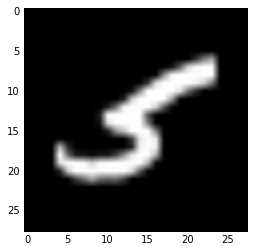

In [7]:
data = mldb.query("""
    SELECT * EXCLUDING(label) 
    FROM sample(
                (select * from digits_mnist where rowHash() % 5 = 0),
                {rows: 1}
    )
""")

image = data.as_matrix().reshape(28, 28)
plt.imshow(image)
plt.gray()

## Defining the convolution function

A discrete convolution can be defined mathematically as:

$newPixel[i,j] = \sum_{y=i}^{i+r}\sum_{x=j}^{j+r}oldPixel[x,y] \cdot weight[x,y]$

where the $weight[]$ matrix (see 'kernelDict' dictionary in a couple of cells below) defines the type of image manipulation and $r$ is the area of effect. Imagine a "square box" centered at the pixel that you want to transform. The kernel weighted sum of "old pixels" in the "square box" gives you a "new pixel".

As seen in the code below, each new pixel in the convolved picture is the weighted sum of the the pixel and its neighboring pixels where the weights are the values in the kernel matrix.  

Doing convolutions with custom function of type [SQL Expression Function](../../../../doc/#builtin/functions/SqlExpressionFunction.md.html) and [jseval](../../../../doc/#builtin/sql/ValueExpression.md.html) for inline definition of functions using Javascript allows us to process large amounts of data using the optimizations inherent to MLDB. Convolutions are typically very time consuming operations with 
$O(n\cdot r^2)$ complexity in this case where n is the number of features and r is the radius (i.e. neighboring pixels).

There were two steps to creating the function below:
* JsConvolutionExpr used a jseval built-in function where all the logic resides
* A 'convolution' SQL Expression Function is created, allowing us to call 'convolution' with a simple [mldb.query](../../../../doc/#builtin/sql/Sql.md.html)

In [106]:
# JavaScript code loosely based on Ivan Kuckir's blog post: http://blog.ivank.net/fastest-gaussian-blur.html

def create_convolution():
    
    JsConvolutionExpr = """
        jseval('
            var row_val = val;
            var dim = Math.sqrt(row_val.length);
            var radius = Math.sqrt(kernel.length);
            
            
            /*************************************
            ******** Function Definition *********
            **************************************/

            // input 1D list, output 1D list, pixel matrix dimensions
            function convolution(inList, outList, width, height, radius) {

                for (var i = 0; i < height; i++)
                    for (var j = 0; j < width; j++) {
                        var newPixel = 0;
                        var indexW = 0;
                        
                        for (var yr = i; yr < i + radius; yr++)
                            for (var xr = j; xr < j + radius; xr++) {
                            
                              var y = Math.min(height - 1, Math.max(0, yr));
                              var x = Math.min(width - 1, Math.max(0, xr));
                              
                              newPixel = newPixel + inList[y * width + x] * weights[indexW];
                              indexW ++;
                            }
                            
                        new_value = newPixel;
                        outList[i * width + j] = new_value;
                    }
                return outList;
            } // End of convolution
            
            //Assuring that the 1d row is in the right order
            function arrangeMatrix(inList) {
            
                var length = inList.length;
                var data = new Array(length);
                for (var i = 0; i < length; i++) {
                    data[parseInt(inList[i][0][0])] = inList[i][1];
                }
                return data
            }
            
            /*************************************
            ********** Using Functions ***********
            **************************************/
            
            var weights = arrangeMatrix(kernel); // filter matrix
            var matrix = arrangeMatrix(row_val); // my picture
            var convolvedMatrix = [];
            
            convolution(matrix, convolvedMatrix, dim, dim, radius);

            return convolvedMatrix;',
            'val, kernel', 
             valueExpr, kernel
        ) AS *
    """


    print mldb.put("/v1/functions/convolution", {
        "type": "sql.expression",
        "params": {
            "expression": JsConvolutionExpr,
            "prepared": True
        }
    })
    
create_convolution()

<Response [201]>


## Using the convolution function

We will first define the type filters or kernels that we want to try.

In [107]:
kernelDict = {
    'Right Sobel': [-1, 0, 1, -2, 0, 2, -1, 0, 1], 
    'Detect Edges': [1, 1, 1, 1, -8, 1, 1, 1, 1],
    'Sharpen': [0, -1, 0, -1, 5, -1, 0, -1, 0],
    'Box Blur': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
    'Approximated Gaussian Blur': [0.0625, 0.125, 0.0625, 0.125, 0.25, 0.125, 0.0625, 0.125, 0.0625]
}

In [108]:
def convolutionFunc(image_processing):
    
    SQL_Expr = """
        SELECT convolution({
                valueExpr: %(data)s,
                kernel: %(kernel)s
        }) AS *
    """ %   {
                "data": data.values[0].tolist(),
                "kernel": kernelDict[image_processing]
            }

    convolvedData = mldb.query(SQL_Expr)
    image = convolvedData.as_matrix().reshape(28, 28)
    plt.imshow(image)

Choose an image processing option from the drop-down menu


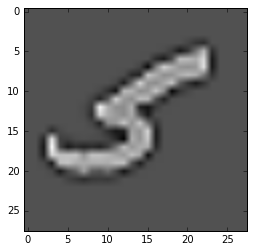

In [109]:
options=('Right Sobel', 'Detect Edges', 'Sharpen', 'Box Blur', 'Approximated Gaussian Blur')
interact(convolutionFunc, image_processing=kernelDict.keys(), );
print "Choose an image processing option from the drop-down menu"

I found the 'Detect Edges' convolution particularly useful when training image recognition models. This can be useful in many Machine Vision applications.

## Convolutions with MLDB's TensorFlow plug-in

Not everyone will want to code their own convolutions from scratch (such as with the `create_convolution()` function above). In fact, given the myriad of tools available, it may save you time and effort to use external librairies. MLDB has integrated the TensorFlow Open Source Library for Machine Intelligence allowing us to leverage some of the great Computer Vision APIs that it offers. Let's get started with the same images as before.

First, I reshape my image and kernel lists into 4D tensors. Then, I use the [`tf_Conv2D`](../../../../doc/builtin/sql/ValueExpression.md.html#builtinfunctions) built-in convolution function.

In [110]:
data_ = data.values[0].reshape(1, 28, 28, 1).tolist() 
# image input must be a [batch, in_height, in_width, in_channels] shaped tensor

In [111]:
def TensorFlowConvolution(image_processing):
    
    kernel = np.asarray(kernelDict[image_processing]).reshape(3, 3, 1, 1).tolist() 
    # kernel must be a [filter_height, filter_width, in_channels, out_channels] shaped tensor
    strides = [ 1, 1, 1, 1]
    SQL_Expr = """
        SELECT tf_Conv2D(
            {input: %(data)s, filter: %(kernel)s}, 
            {T: { type: 'DT_FLOAT'}, padding: 'SAME', strides: %(strides)s })
        AS *
    """ %   {
                "data": data_,
                "kernel": kernel,
                "strides": strides
            }
    
    convolvedData = mldb.query(SQL_Expr)
    image = convolvedData.as_matrix().reshape(28, 28)
    plt.imshow(image)

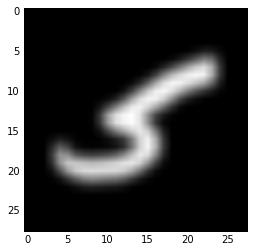

In [88]:
options=('Right Sobel', 'Detect Edges', 'Sharpen', 'Box Blur', 'Approximated Gaussian Blur')
interact(TensorFlowConvolution, image_processing=kernelDict.keys(), );
print "Choose an image processing option from the drop-down menu"

Here are a few definitions:
* Batch: The data is sometimes split into batches to parallelize Neural Network training and provide more frequent updates Neural Network weights. For more information, see Carnegie Mellon University's paper on [Efficient Mini-batch Training for Stochastic Optimization](https://www.cs.cmu.edu/~muli/file/minibatch_sgd.pdf). In our example, we only have one unsplit batch.
* Strides: Stride is a step that the "square box" (as described in 'Defining the Convolution Function' section above) will take. A stride has shape [stride_batch, stride_width, stride_height, stride_channel] so [1, 1, 1, 1] will shift the box one pixel at the time for each batch and each channel.
* Padding: As you may have noticed, sometimes the "square box" has elements outside the picture (i.e. for pixels at the boundries of the image). The 'SAME' padding allows the convolution algorithm to go beyond picture borders. Pixels in the padding area will typically be zero and the output image will have the same size as the input image. 'VALID' padding does not allow the "square box" to go beyond the picture boundries. In this case, the output picture size will be smaller. For moreinformation, see [this article](http://radio.feld.cvut.cz/matlab/toolbox/images/linfilt4.html).
* Channel: we have only one channel here because it is grayscale. For images with colors (i.e. RGB), we have 3 channels. See ImageMagick's [Color Basics and Channels](http://www.imagemagick.org/Usage/color_basics/) article for more information.

## Where to next?

If you are interested in building your own custom image manipulation algorithms, you can click [here](../../../../ipy/notebooks/_demos/Convolutions%20using%20SQL%20and%20javascript.ipynb) to jump to the Convolution Demo. Otherwise, check out the other [Tutorials and Demos](../../../../doc/#builtin/Demos.md.html).